# Intro Task, Object Localization 

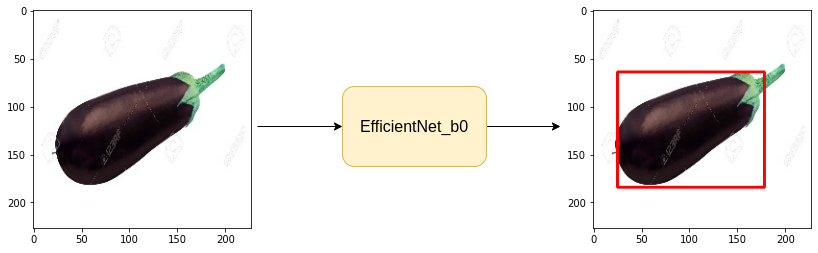

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-zq52lqx_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-zq52lqx_
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=124195 sha256=2fa126cb48a69b4324b9fd9b5cc25ce874cb33a658695ad31520b0764a8b543a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9pqqpxse/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 8.4 MB/s 
     |████████████████████

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
csv = '/content/object-localization-dataset/train.csv'
directory = '/content/object-localization-dataset/'

device = 'cuda' #This project will be fully utilizing GPU
batch_size = 16
img_size = 140

LR = 0.001
Epochs = 40
model_name = 'efficientnet_b0'
num_coordinates = 4

In [6]:
dataFrame = pd.read_csv(csv)
dataFrame

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

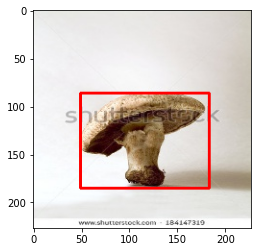

In [7]:
row = dataFrame.iloc[2]
img = cv2.imread(directory + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
point_1 = (row.xmin, row.ymin)
point_2 = (row.xmax, row.ymax)
bounding_box = cv2.rectangle(img, point_1, point_2, (255, 0, 0), 2)
plt.imshow(bounding_box)

In [8]:
train_df, valid_df = train_test_split(dataFrame, train_size = 0.8, random_state = 42)

In [9]:
train_df

,img_path,xmin,ymin,xmax,ymax,width,height,label
123,train_images/eggplant_32.jpg,20,72,211,152,227,227,eggplant
135,train_images/eggplant_43.jpg,56,35,145,212,227,227,eggplant
150,train_images/eggplant_38.jpg,19,49,210,169,227,227,eggplant
31,train_images/eggplant_14.jpg,59,41,206,149,227,227,eggplant
12,train_images/eggplant_53.jpg,29,36,171,198,227,227,eggplant
...,...,...,...,...,...,...,...,...
106,train_images/eggplant_1.jpg,2,5,214,225,227,227,eggplant
14,train_images/eggplant_39.jpg,17,30,212,186,227,227,eggplant
92,train_images/eggplant_4.jpg,36,72,205,187,227,227,eggplant
179,train_images/eggplant_60.jpg,24,75,184,161,227,227,eggplant


# Augmentations

In [10]:
import albumentations as A

In [11]:
from albumentations.core.bbox_utils import BboxParams
train_augment = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augment = A.Compose([
    A.Resize(img_size, img_size),
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [12]:
from torch.utils.data import Dataset
class dataset(Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    
    bbox = [[xmin, ymin, xmax, ymax]]
    img_path = directory + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None]) #Augmented Data in dictionary format
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 #(h, w, c) -> (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [13]:
train_set = dataset(train_df, train_augment)
valid_set = dataset(valid_df, valid_augment)

In [14]:
print(f"Total examples in the train dataset: {len(train_set)}")
print(f"Total examples in the validation dataset: {len(valid_set)}")

Total examples in the train dataset: 148
Total examples in the validation dataset: 38


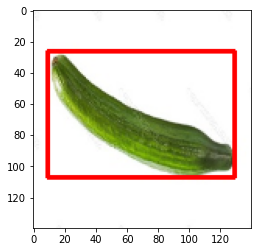

In [15]:
img, bbox = train_set[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size = batch_size, shuffle = True)

In [17]:
print("Total no. batches in trainloader : {}".format(len(train_loader)))
print("Total no. batches in validloader : {}".format(len(valid_loader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [18]:
for images, bboxes in train_loader:
 break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [19]:
from torch import nn 
import timm

In [20]:
class Model(nn.Module):

  def __init__(self):
    super(Model, self).__init__()

    self.backbone = timm.create_model(model_name, pretrained = True, num_classes = 4) #Output only the logits, no softmax or sigmoid

  def forward(self, images, gt_bboxes = None):
    logits_bbox = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(logits_bbox, gt_bboxes)
      return logits_bbox, loss
    else:
      return logits_bbox

In [21]:
model = Model()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


Model(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1),

# Create Train and Eval Function

In [22]:
def train(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() #Dropout layer is ON when doing any gradient computation
  
  #tqdm  used in order to track the batches or loop

  for data in tqdm(dataloader):
    images, gt_bbox = data
    images, gt_bbox = images.to(device), gt_bbox.to(device)

    bboxes, loss = model(images, gt_bbox)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)     

In [23]:
def valid(model, dataloader):
  total_loss = 0.0
  model.eval() #Dropout layer is ON when doing any gradient computation
  
  #tqdm  used in order to track the batches or loop
  
  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bbox = data
      images, gt_bbox = images.to(device), gt_bbox.to(device)
      
      bboxes, loss = model(images, gt_bbox)
      total_loss += loss.item()
    
    return total_loss/len(dataloader)  

#Training Loop

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [25]:
best_valid_loss = np.Inf

for epoch in range(Epochs):
  train_loss = train(model, train_loader, optimizer)
  valid_loss =  valid(model, valid_loader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weights are saved")
    best_valid_loss = valid_loss
  
  print(f"Epochs {epoch + 1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 1 train loss: 5295.675390625 valid loss: 4858.7470703125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 2 train loss: 2002.2027954101563 valid loss: 3149.2447916666665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 3 train loss: 1207.5641235351563 valid loss: 352.43312581380206


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 4 train loss: 769.3397644042968 valid loss: 249.6015828450521


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 5 train loss: 543.276254272461 valid loss: 204.7738291422526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 6 train loss: 398.90122985839844 valid loss: 202.8614501953125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 7 train loss: 306.69391479492185 valid loss: 148.01791381835938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 8 train loss: 239.96898956298827 valid loss: 195.50458272298178


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 9 train loss: 182.8963310241699 valid loss: 117.82611083984375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 10 train loss: 152.14637451171876 valid loss: 194.05636596679688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 11 train loss: 122.00823059082032 valid loss: 195.91729736328125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 12 train loss: 118.84179916381837 valid loss: 150.22337849934897


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 13 train loss: 100.52425918579101 valid loss: 106.51420593261719


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 14 train loss: 97.33086242675782 valid loss: 113.1039530436198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 15 train loss: 83.79067878723144 valid loss: 99.70517985026042


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 16 train loss: 84.15607070922852 valid loss: 95.85225423177083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 17 train loss: 65.4098949432373 valid loss: 87.97366078694661


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 18 train loss: 72.52794570922852 valid loss: 81.28991444905598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 19 train loss: 64.42659530639648 valid loss: 81.0812390645345


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 20 train loss: 57.762827682495114 valid loss: 59.897759755452476


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 21 train loss: 62.86626510620117 valid loss: 68.11450322469075


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 22 train loss: 63.97231903076172 valid loss: 110.27101135253906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 23 train loss: 72.19340057373047 valid loss: 85.32841491699219


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 24 train loss: 60.563975715637206 valid loss: 81.72290293375652


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 25 train loss: 66.31232299804688 valid loss: 92.32835388183594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 26 train loss: 56.432039451599124 valid loss: 78.39784749348958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 27 train loss: 62.993821716308595 valid loss: 56.471226374308266


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 28 train loss: 55.514144325256346 valid loss: 48.18095270792643


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 29 train loss: 49.198652267456055 valid loss: 72.18174743652344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 30 train loss: 51.301689338684085 valid loss: 54.177633921305336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 31 train loss: 48.08607730865479 valid loss: 48.00131861368815


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 32 train loss: 54.92270488739014 valid loss: 83.15319188435872


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 33 train loss: 44.16859664916992 valid loss: 65.2799466451009


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 34 train loss: 45.817427253723146 valid loss: 69.90681966145833


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 35 train loss: 52.17669277191162 valid loss: 75.52490743001302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 36 train loss: 39.220103645324706 valid loss: 66.87605285644531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 37 train loss: 50.99068622589111 valid loss: 82.91031265258789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 38 train loss: 39.494962501525876 valid loss: 60.65597915649414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epochs 39 train loss: 37.68585205078125 valid loss: 45.533477783203125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 40 train loss: 30.17891654968262 valid loss: 59.36178080240885


#Inference

In [26]:
import utils

In [27]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

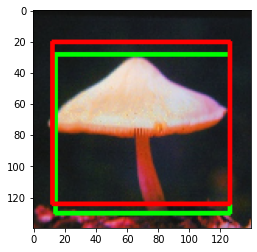

In [34]:
model.eval()

with torch.no_grad():
  image, gt_bbox = valid_set[5] # shape (c, w, h)
  image = image.unsqueeze(0).to(device) # shape (batch_size, c, w, h) Adding batch_size by faking it on 0-axis
  
  out_bbox = model(image)
  
  utils.compare_plots(image, gt_bbox, out_bbox)


In [35]:
# Predicted bounding box Vs Actual bounding box